In [1]:
from sklearn.feature_selection import SelectFdr, f_classif
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import wilcoxon
from scipy.stats import ranksums
# from statsmodels.stats.multitest import fdrcorrection
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif,f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, mean_squared_error, precision_score, jaccard_score, fowlkes_mallows_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from boruta import BorutaPy
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split

In [4]:
rna = pd.read_csv('D:/multiomics/2025june/rna_rb.csv', sep=',')
lipid = pd.read_csv('D:/multiomics/2025june/lipid_rb.csv', sep=',')
meta = pd.read_csv('D:/multiomics/2025june/meta_rb.csv', sep=',')

In [5]:
sets_to_intersect = [
    set(rna['id']),
    set(lipid['id']),
    set(meta['id'])
]


common_ids = set.intersection(*sets_to_intersect)


sorted_common_ids = sorted(common_ids)


meta = meta[meta['id'].isin(common_ids)].set_index('id').loc[sorted_common_ids].reset_index()
lipid = lipid[lipid['id'].isin(common_ids)].set_index('id').loc[sorted_common_ids].reset_index()
rna = rna[rna['id'].isin(common_ids)].set_index('id').loc[sorted_common_ids].reset_index()

In [6]:
sum(rna['id']==meta['id']),sum(rna['id']==lipid['id'])

(249, 249)

In [7]:
f_rna = rna.iloc[:,14:]
f_lipid = lipid.iloc[:,6:]
f_meta = meta.iloc[:,6:]
f_agender = rna.iloc[:,1:3]

In [8]:
du = (rna['sVNT_M1_WT_RBD_10_times_dilution']-rna['sVNT_M6_WT_RBD_10_times_dilution'])/rna['sVNT_M1_WT_RBD_10_times_dilution']

In [9]:
min(du)

-0.010641604290917919

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

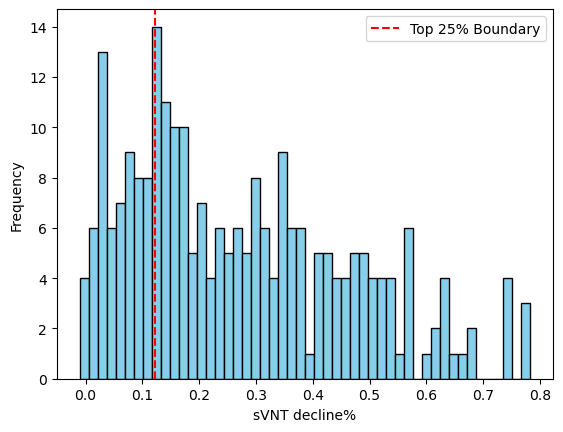

In [13]:
df_sorted = du.sort_values(ascending=False)


top_25_percent_index = int(len(df_sorted) * 0.75)
top_25_values = df_sorted.iloc[:top_25_percent_index]


plt.hist(du, bins=50, color='skyblue', edgecolor='black') 
plt.xlabel('sVNT decline%')
plt.ylabel('Frequency')  


plt.axvline(x=top_25_values.iloc[-1], color='red', linestyle='--', label='Top 25% Boundary')
plt.legend() 
plt.show() 

In [14]:
top_25_values.iloc[-1]

0.12156589464776099

In [15]:
du.quantile(0.25)

0.1212476424599795

In [16]:
(du<=du.quantile(0.25))*1

0      1
1      0
2      1
3      0
4      0
      ..
244    0
245    0
246    0
247    0
248    0
Length: 249, dtype: int32

In [17]:
sum((du<=du.quantile(0.25))*1)

63

In [18]:
label = (du<=du.quantile(0.25))*1

In [19]:
batch_label = pd.concat([rna[['id','Age','Gender','Batch']], label], axis=1) 
batch_label = batch_label.rename(columns={0: 'label'})

In [20]:
batch_label

,id,Age,Gender,Batch,label
0,VA001,52,1,Batch01,1
1,VA003,33,0,Batch02,0
2,VA004,49,1,Batch02,1
3,VA005,46,0,Batch01,0
4,VA006,36,0,Batch02,0
...,...,...,...,...,...
244,VA651,70,1,Batch02,0
245,VA653,51,0,Batch01,0
246,VA654,54,0,Batch01,0
247,VA656,42,0,Batch01,0


In [21]:
batch_label['batch_label'] = (
    batch_label['Batch'].astype(str).str.cat(batch_label['label'].astype(str), sep='_')
)

In [22]:
cross_table = pd.crosstab(batch_label['label'], batch_label['Batch'])

In [23]:
cross_table

Batch,Batch01,Batch02
label,,
0,97,89
1,24,39


In [24]:
label

0      1
1      0
2      1
3      0
4      0
      ..
244    0
245    0
246    0
247    0
248    0
Length: 249, dtype: int32

In [25]:
f_lipid

,ChE.16.1.,ChE.18.1.,ChE.18.2.,ChE.18.2..rep.,ChE.18.3.,ChE.20.3.,ChE.20.4..rep.,ChE.22.6.,Co.Q10.,Co.Q9.,...,SM.d41.2.,SM.d41.3.,SM.d42.1..rep.,SM.d42.2.,SM.d43.2.,SM.d43.4.,SM.d43.5.,SM.d44.1.,SM.d44.3.,SM.d44.5.
0,3.367411,8.157624,3.145579,3.436596,55.512583,6.131788,2.274213,1.611605,1.310677,0.519494,...,3.783011,3.168323,2.637546,14.190264,5.354687,2.740469,1.015831,2.161989,2.688676,1.460813
1,0.907273,2.212778,1.532345,1.404114,-1.151783,1.278634,1.119296,1.520687,0.777254,1.001807,...,4.856674,4.350040,1.333709,12.577416,0.935937,2.002758,1.021257,1.334899,2.423517,1.120107
2,1.707851,16.289750,5.086852,4.657376,-2.776968,6.973961,4.191897,2.724525,1.173732,0.883735,...,6.721957,5.800256,4.145034,16.464247,4.915338,4.184190,2.098199,3.790251,4.268463,1.428810
3,3.434909,10.850421,3.057179,3.029090,23.180733,4.074706,4.745094,4.285053,0.951318,0.276032,...,3.277240,7.040314,0.855745,16.898179,8.747479,1.718321,1.490571,1.986419,3.212428,1.828404
4,3.049907,9.375586,3.343565,3.234164,-0.972781,3.500392,2.141383,1.975598,0.827189,0.724143,...,3.442920,3.765596,2.471026,12.543222,3.516313,0.159375,1.304903,2.308284,2.301817,1.264167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,3.602018,9.579104,2.773291,2.858084,-3.785041,5.419952,7.885971,3.786816,1.285607,1.463333,...,3.674709,5.976432,0.659737,16.432946,1.644304,0.573989,1.469137,0.899511,5.603814,2.783215
245,1.245573,6.725367,1.816033,2.030624,-0.097286,3.393542,0.813927,0.995736,1.346219,1.414702,...,3.644076,4.284894,2.138605,15.499924,0.903524,2.599815,1.154195,1.660664,2.894363,1.168618
246,1.978347,9.456196,2.582722,2.541941,-0.048621,3.749168,2.678535,2.724769,1.183772,1.283929,...,3.657712,5.122327,2.138243,22.264307,5.495789,2.883611,1.470054,1.366502,2.407144,1.582182
247,1.216607,7.409304,2.909421,2.621884,0.004234,2.699690,1.429237,0.904946,0.837197,2.148519,...,1.826225,5.478639,0.512971,23.300386,1.311268,0.334145,0.635586,1.154731,2.299336,1.701860


In [26]:
combine = pd.concat([f_rna, f_lipid, f_meta], axis=1) 
combine = pd.concat([f_agender, combine], axis=1)

In [29]:
batch_label['batch_label']

0      Batch01_1
1      Batch02_0
2      Batch02_1
3      Batch01_0
4      Batch02_0
         ...    
244    Batch02_0
245    Batch01_0
246    Batch01_0
247    Batch01_0
248    Batch01_0
Name: batch_label, Length: 249, dtype: object

In [35]:
X_train, X_test, y_train, y_test = train_test_split(combine, label, test_size=0.2,stratify=batch_label['batch_label'],random_state=42)

In [36]:
batch_label['batch_label'][X_train.index]

95     Batch01_0
221    Batch01_0
157    Batch01_0
245    Batch01_0
86     Batch02_0
         ...    
82     Batch02_1
8      Batch02_1
153    Batch01_0
128    Batch02_0
98     Batch02_0
Name: batch_label, Length: 199, dtype: object

In [55]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from functools import partial
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import f_classif
from joblib import Parallel, delayed
import pandas as pd

def process_fold(train_idx, val_idx, i, X_train, y_train):
    print(f"Processing fold {i}")
    

    X_fold_train, y_fold_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
    

    F_values, p_values = f_classif(X_fold_train, y_fold_train)
    significant_features_mask = p_values < 0.1
    significant_features = X_fold_train.columns[significant_features_mask]
    print(f"Fold {i+1}: {len(significant_features)} significant features")
    X_fold_train_sig = X_fold_train[significant_features]

    estimator = RandomForestClassifier(random_state=42, n_jobs=-1)
    

    boruta_selector = BorutaPy(
        estimator=estimator,
        n_estimators='auto',  
        verbose=0,         
        random_state=42,
        max_iter=100,        
        perc=90,alpha=0.1           
    )
    

    boruta_selector.fit(X_fold_train_sig.values, y_fold_train.values)
    

    selected_features_mask = boruta_selector.support_
    selected_features = significant_features[selected_features_mask]
    

    estimator.fit(X_fold_train_sig[selected_features], y_fold_train)
    importances = estimator.feature_importances_
    

    return [
        {
            'fold': i,
            'feature': feature,
            'importance': importance,
        }
        for feature, importance in zip(selected_features, importances)
    ]


def main():

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    

    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(partial(process_fold, X_train=X_train, y_train=y_train))(train_idx, val_idx, i)
        for i, (train_idx, val_idx) in enumerate(cv.split(X_train, batch_label['batch_label'][X_train.index]))
    )
    

    results = [item for sublist in results for item in sublist]
    

    results_df = pd.DataFrame(results)
    

    results_df = results_df.sort_values(['fold', 'importance'], ascending=[True, False])

    print(results_df.head())
    return results_df

if __name__ == '__main__':
    all_feature_counts = main()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  2.5min remaining:  5.7min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  2.5min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  2.5min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.6min finished


    fold                                     feature  importance
77     0  ENSG00000189269.12__DRICH1__protein.coding    0.018546
36     0  ENSG00000139734.19__DIAPH3__protein.coding    0.014585
90     0           ENSG00000211933.2__IGHV6.1__other    0.013995
97     0          ENSG00000223891.7__OSER1.DT__ncRNA    0.013963
38     0    ENSG00000143248.13__RGS5__protein.coding    0.011752


In [85]:
all_feature_counts

,fold,feature,importance
77,0,ENSG00000189269.12__DRICH1__protein.coding,0.018546
36,0,ENSG00000139734.19__DIAPH3__protein.coding,0.014585
90,0,ENSG00000211933.2__IGHV6.1__other,0.013995
97,0,ENSG00000223891.7__OSER1.DT__ncRNA,0.013963
38,0,ENSG00000143248.13__RGS5__protein.coding,0.011752
...,...,...,...
1830,9,ENSG00000005844.19__ITGAL__protein.coding,0.002651
1920,9,ENSG00000196465.10__MYL6B__protein.coding,0.002601
1846,9,ENSG00000100206.11__DMC1__protein.coding,0.002480
1885,9,ENSG00000161847.14__RAVER1__protein.coding,0.002212


In [87]:
feature_counts = all_feature_counts['feature'].value_counts()
common_features = feature_counts[feature_counts >= 9].index
df_filtered = all_feature_counts[all_feature_counts['feature'].isin(common_features)]

stats = df_filtered.groupby('feature')['importance'].agg(['sum', 'mean', 'count'])
stats = stats.sort_values('count', ascending=False)

top_feature = stats.index[:32]
feature_selected = list(top_feature)

In [88]:
feature_selected

['ENSG00000196465.10__MYL6B__protein.coding',
 'ENSG00000270106.6__TSNAX.DISC1__ncRNA',
 'ENSG00000227200.1__NA__NA',
 'ENSG00000189269.12__DRICH1__protein.coding',
 'ENSG00000181350.12__LRRC75A__protein.coding',
 'ENSG00000232611.1__NA__NA',
 'ENSG00000177398.19__UMODL1__protein.coding',
 'ENSG00000243701.8__DUBR__ncRNA',
 'ENSG00000139734.19__DIAPH3__protein.coding',
 'ENSG00000132846.6__ZBED3__protein.coding',
 'ENSG00000112183.15__RBM24__protein.coding',
 'ENSG00000273204.1__NA__NA',
 'ENSG00000223379.1__NA__NA',
 'ENSG00000245468.5__NA__NA',
 'ENSG00000243819.4__RN7SL832P__pseudo',
 'ENSG00000211933.2__IGHV6.1__other',
 'ENSG00000237359.2__NA__NA',
 'ENSG00000234902.6__NA__NA',
 'ENSG00000228158.2__NA__NA',
 'ENSG00000275185.1__NA__NA',
 'ENSG00000223891.7__OSER1.DT__ncRNA',
 'ENSG00000000971.16__CFH__protein.coding',
 'ENSG00000211896.7__IGHG1__other',
 'ENSG00000206120.11__NA__NA',
 'ENSG00000205609.13__EIF3CL__protein.coding',
 'ENSG00000067836.13__ROGDI__protein.coding',
 'ENS

In [93]:
# Prepare training and test sets
Xtrain = X_train[['Age', 'Gender'] + feature_selected]
Xtest = X_test[['Age', 'Gender'] + feature_selected]

# Initialize and train Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(Xtrain, y_train)

# Predict probabilities for the positive class
y_pred_proba = rf.predict_proba(Xtest)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)

print(f'{auc:.2f}')

0.84
